# Predict Loan Eligibility for Dream Housing Finance company
Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 



In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

# **EDA**
Before going to any kind of modelling, we will always want to have a look at the kind of data that we have.

We have been provided three files. A description for what each of these files contain is given below:

**SampleSubmission.csv:** This gives us a required format for submitting our solutions to the AV solution checker.
**Train.csv:** We will use this file for training our model. It contains variables or features that we will input to our model, and the target variable that we want to predict.
**Test.csv:** This will contain all variables in the training dataset except the target variable. We will use our trained model to predict the target for this dataset.
Now lets go on to read and have a look at each of the files.

In [2]:
ss = pd.read_csv('sample_submission_49d68Cx.csv')
test = pd.read_csv('test_lAUu6dG.csv')
train = pd.read_csv('train_ctrUa4K.csv')

In [3]:
ss.head()

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N


In [4]:
train.head(3)
test.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban


In [5]:
#sampleDF['housing'] = sampleDF['housing'].map({'yes': 1, 'no': 0})
train['Loan_Status'] = train['Loan_Status'].map({'Y': 1, 'N': 0})

In [6]:
ID_COL, TARGET_COL = 'Loan_ID', 'Loan_Status'

In [7]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 614 samples and 13 variables

Test contains 367 samples and 12 variables

The dataset contains 11 features


In [8]:
train[TARGET_COL].value_counts(normalize=True)

1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64

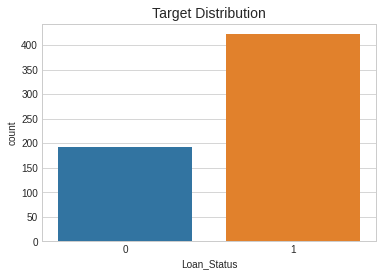

In [9]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ KB


In [11]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Credit_History       8.1
Self_Employed        5.2
LoanAmount           3.6
Dependents           2.4
Loan_Amount_Term     2.3
Gender               2.1
Married              0.5
Loan_Status          0.0
Property_Area        0.0
CoapplicantIncome    0.0
ApplicantIncome      0.0
Education            0.0
Loan_ID              0.0
dtype: float64

In [12]:
train.nunique()

Loan_ID              614
Gender               2  
Married              2  
Dependents           4  
Education            2  
Self_Employed        2  
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term     10 
Credit_History       2  
Property_Area        3  
Loan_Status          2  
dtype: int64

In [13]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [14]:
cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Loan_Amount_Term', 'Credit_History', 'Property_Area']

In [15]:
num_cols = [c for c in features if c not in cat_cols]
num_cols

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

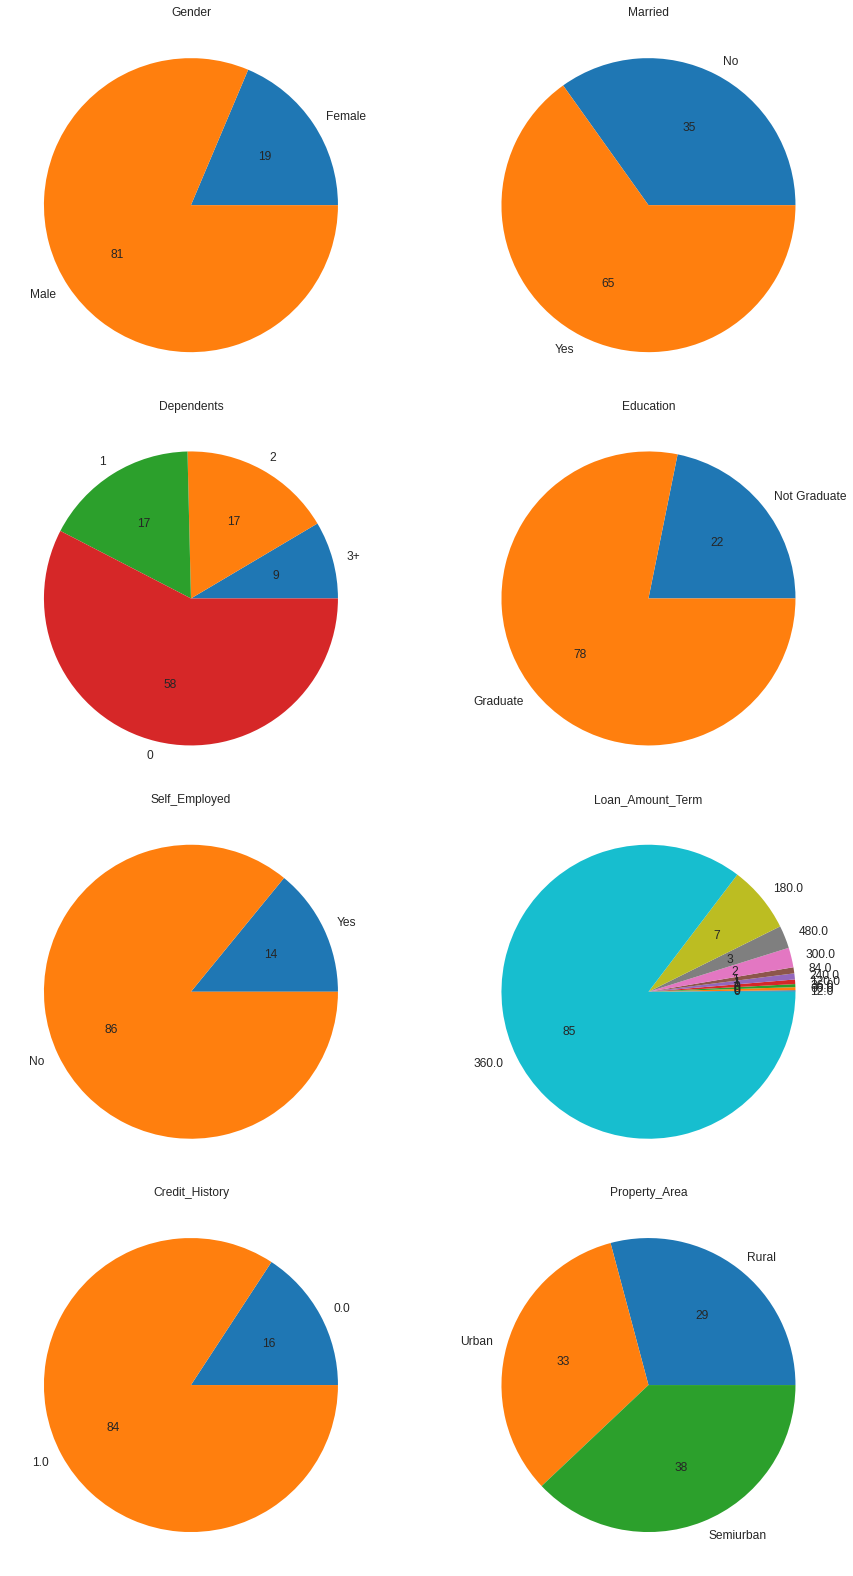

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

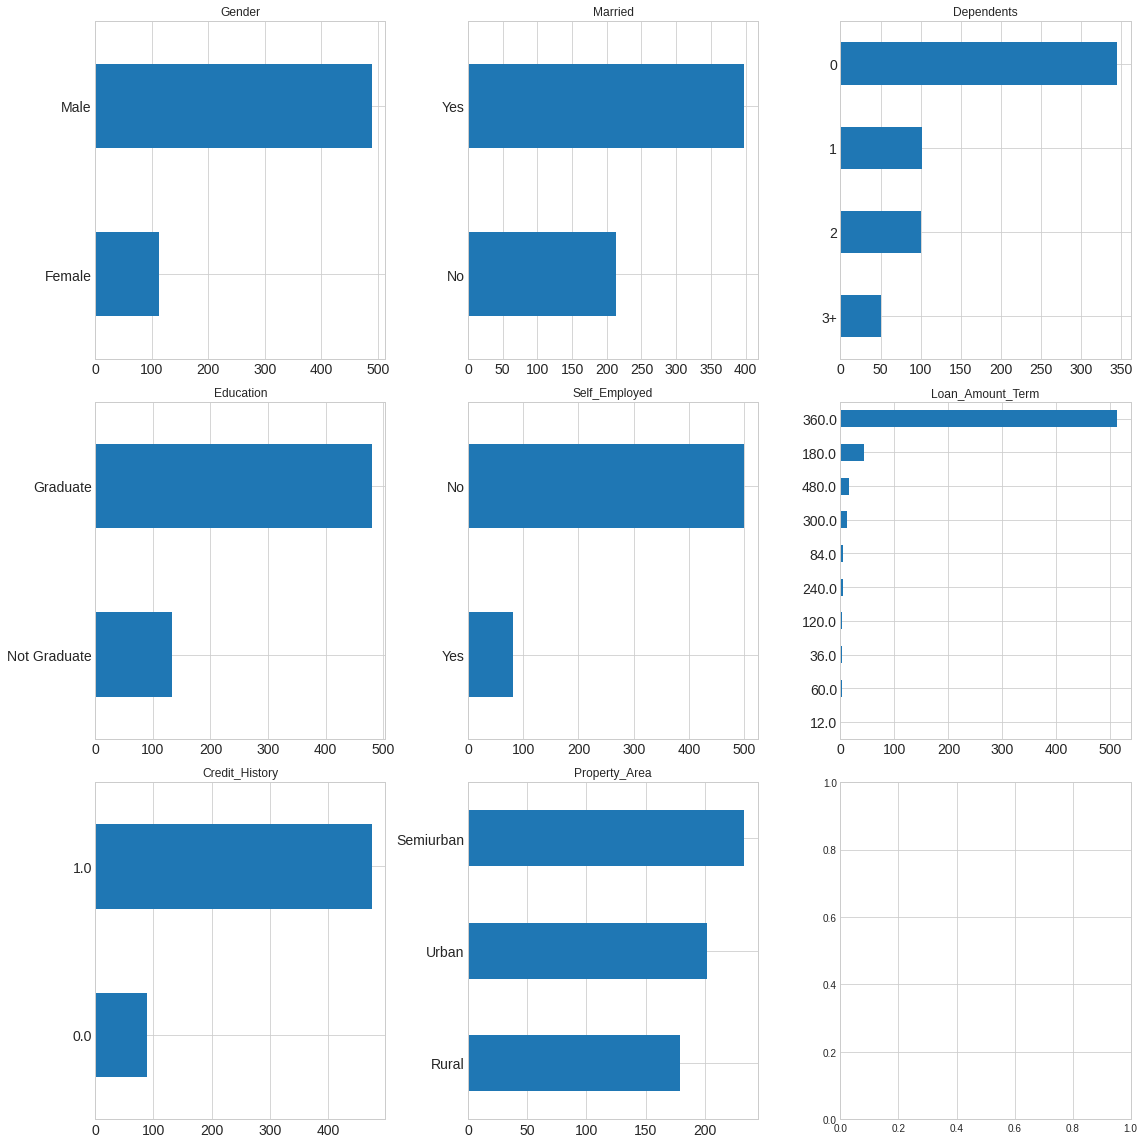

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

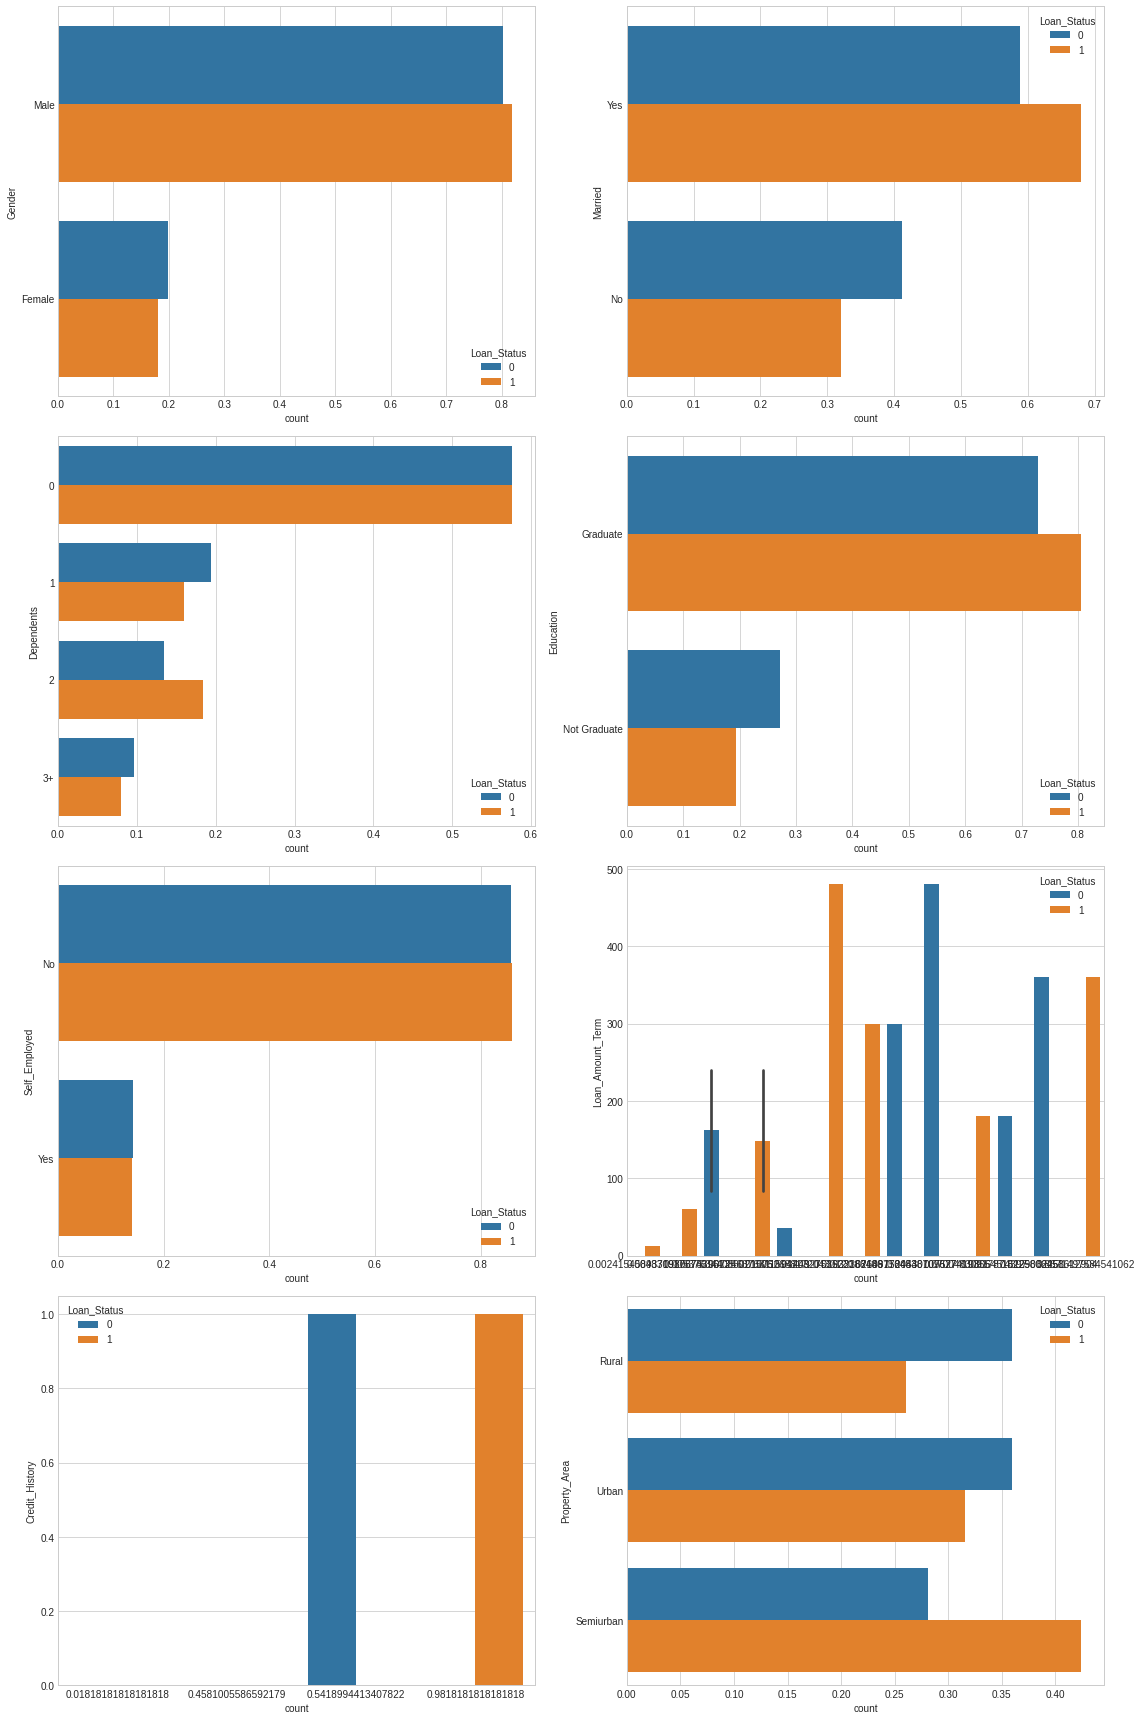

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

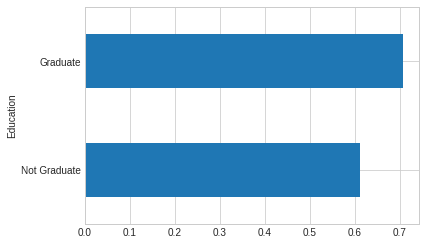

In [19]:
_ = train.groupby('Education')[TARGET_COL].mean().sort_values().plot(kind = 'barh')

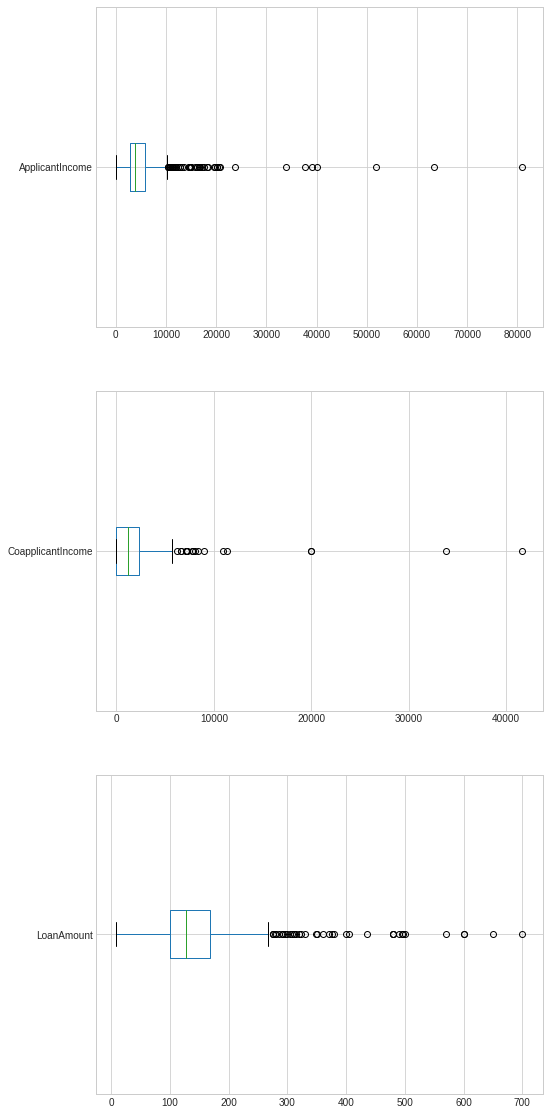

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

In [22]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


In [23]:
# #Check it once again
# sns.set(font_scale=1.3)
# fig, axes = plt.subplots(4, 2, figsize=(18, 14))
# axes = [ax for axes_row in axes for ax in axes_row]
# for i, c in enumerate(num_cols):
#   plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
# plt.tight_layout()

In [24]:
# sns.set(font_scale=1.3)
# fig, axes = plt.subplots(4, 2, figsize=(18, 14))
# axes = [ax for axes_row in axes for ax in axes_row]
# for i, c in enumerate(num_cols):
#   plot = sns.kdeplot(data=train, x=c, hue=TARGET_COL, multiple='fill', ax=axes[i])
# plt.tight_layout()

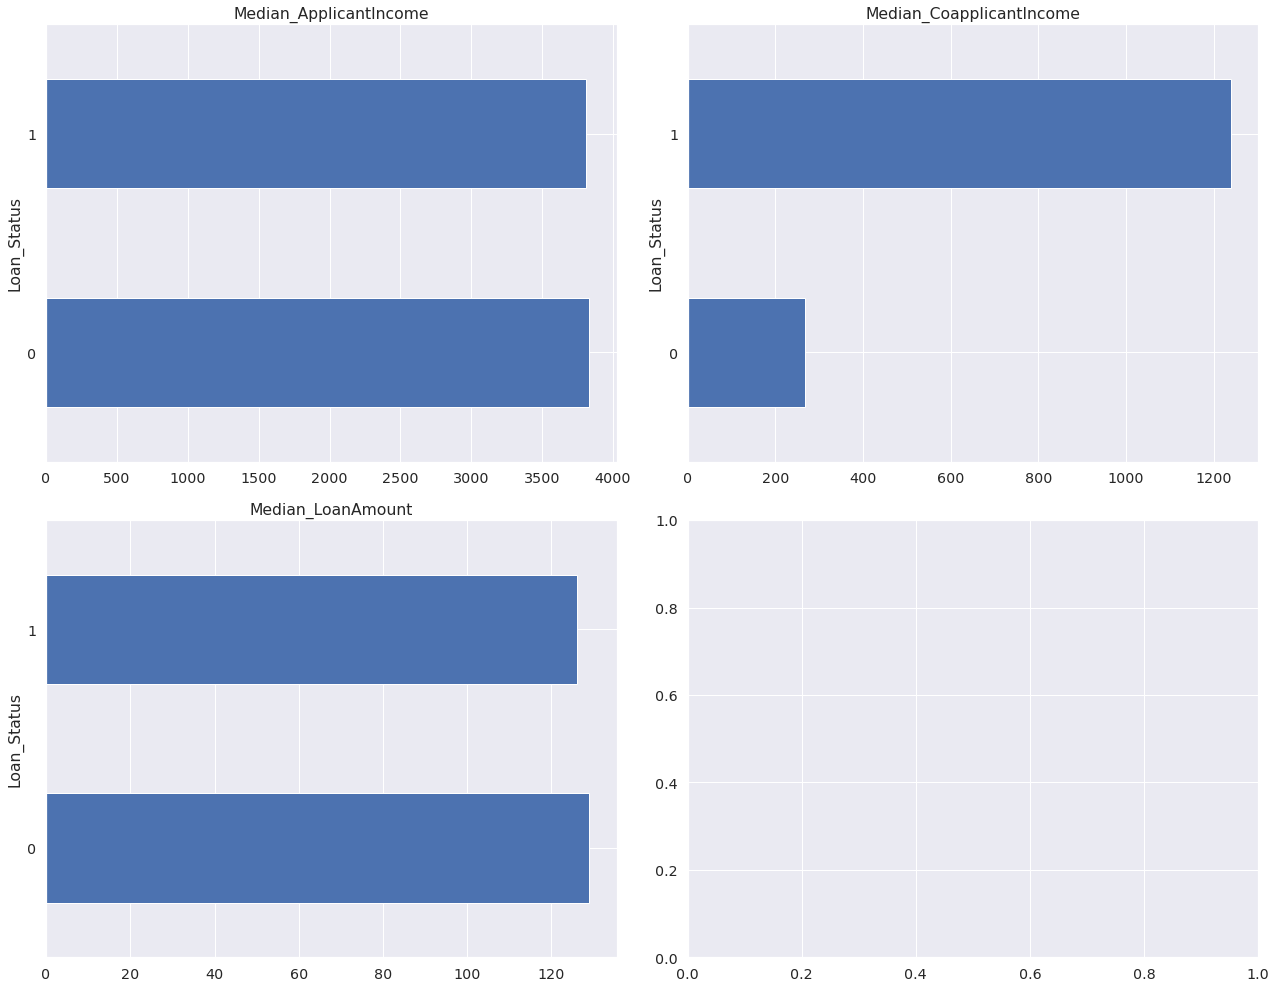

In [25]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

<Figure size 360x360 with 0 Axes>

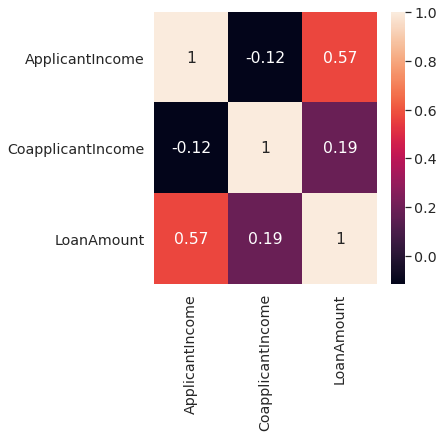

In [26]:
plt.figure(figsize=(5, 5))
_ = sns.heatmap(train[num_cols].corr(), annot=True)

In [27]:
target = train[TARGET_COL]
target.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [28]:
#BaseLine Models
def download_preds(preds_test, file_name = 'Loan_Pred.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test
  ss[TARGET_COL] = ss[TARGET_COL].map({1: 'Y', 0: 'N'})
  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

In [29]:
preds_target = np.zeros(len(train))

accuracy = accuracy_score(target, preds_target)
f1 = f1_score(target, preds_target)

print(f'Accuracy score is: {accuracy}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.3127035830618892
F1 score is: 0.0


In [30]:
preds_test = np.zeros(len(test))

In [31]:
download_preds(preds_test, file_name = 'Loan_Pred_Zero.csv')

In [32]:
#Random with probability
np.random.seed(2)

preds_target = np.random.choice([0, 1], size=len(train))


accuracy = accuracy_score(target, preds_target)
f1 = f1_score(target, preds_target)

print(f'Accuracy score is: {accuracy}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.503257328990228
F1 score is: 0.5827633378932969


In [33]:
np.random.seed(2)
preds_test = np.random.choice([0, 1], size=len(test))
download_preds(preds_test, file_name = 'Loan_Pred_Prob.csv')

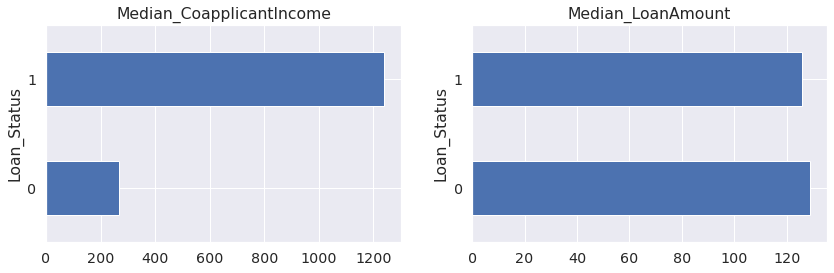

In [34]:
#Rule Based: Classifying using Most Important Feature(s)
sns.set(font_scale=1.3)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for i, c in enumerate(['CoapplicantIncome', 'LoanAmount']):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])

In [35]:
def rule_based_clf(df):
  preds = np.ones(len(df))
  rule = (df['CoapplicantIncome'] < 250) | (df['CoapplicantIncome'] < 1200)
  preds[rule] = 0
  return preds

In [36]:
preds_train = rule_based_clf(train)
accuracy = accuracy_score(target, preds_target)
f1 = f1_score(target, preds_target)

print(f'Accuracy score is: {accuracy}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.503257328990228
F1 score is: 0.5827633378932969


In [37]:
preds_test = rule_based_clf(test)
download_preds(preds_test, file_name='Load_Pred_rule_based_2.csv')

In [38]:
!pip install -q catboost
!pip install -q --upgrade seaborn

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
#from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [40]:
?pd.get_dummies

In [41]:
pd.get_dummies(train[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']])

,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
2,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1
3,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0
610,0,1,0,1,0,0,0,1,1,0,1,0,1,0,0
611,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
612,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1


In [42]:
train.shape, test.shape

((614, 13), (367, 12))

In [43]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(981, 13)

In [44]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1.0


In [45]:
df = pd.get_dummies(df, columns = cat_cols)

In [46]:
df.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Loan_Amount_Term_240.0,Loan_Amount_Term_300.0,Loan_Amount_Term_350.0,Loan_Amount_Term_360.0,Loan_Amount_Term_480.0,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849,0.0,NaN,1.0,0,1,1,0,1,...,0,0,0,1,0,0,1,0,0,1
1,LP001003,4583,1508.0,128.0,0.0,0,1,0,1,0,...,0,0,0,1,0,0,1,1,0,0
2,LP001005,3000,0.0,66.0,1.0,0,1,0,1,1,...,0,0,0,1,0,0,1,0,0,1
3,LP001006,2583,2358.0,120.0,1.0,0,1,0,1,1,...,0,0,0,1,0,0,1,0,0,1
4,LP001008,6000,0.0,141.0,1.0,0,1,1,0,1,...,0,0,0,1,0,0,1,0,0,1


In [47]:
df.shape

(981, 34)

In [48]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [49]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [50]:
len(features)

32

In [51]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]


In [52]:
X_trn.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,...,Loan_Amount_Term_240.0,Loan_Amount_Term_300.0,Loan_Amount_Term_350.0,Loan_Amount_Term_360.0,Loan_Amount_Term_480.0,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
458,4354,0.0,136.0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
361,5000,3667.0,236.0,0,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
365,6216,0.0,133.0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
94,3620,0.0,25.0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
401,2755,0.0,65.0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0


In [53]:
X_val.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,...,Loan_Amount_Term_240.0,Loan_Amount_Term_300.0,Loan_Amount_Term_350.0,Loan_Amount_Term_360.0,Loan_Amount_Term_480.0,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
22,2600,1911.0,116.0,0,1,0,1,1,0,0,...,0,0,0,1,0,1,0,0,1,0
604,12000,0.0,496.0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,1,0
181,1916,5063.0,67.0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
85,2366,2531.0,136.0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
391,9504,0.0,275.0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,1,0,0


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [55]:
X_trn.shape

(491, 32)

In [56]:
X_trn[:,0]

array([-1.75281542e-01, -6.60296823e-02,  1.39620878e-01, -2.99416009e-01,
       -4.45705264e-01,  2.58358160e+00, -1.08309814e-01,  1.01921673e+00,
        4.67737087e-02, -3.02629299e-01, -3.07533794e-01, -5.89266202e-02,
        7.05159917e-01, -4.89000118e-01,  3.28528505e-01,  8.03080702e-01,
       -3.26644413e-01, -8.97065560e-02, -2.10436223e-02, -3.36622524e-01,
       -5.63582271e-01,  2.35512216e-01, -1.12876068e-01, -1.06956850e-01,
       -4.13234123e-01, -9.25816049e-02,  1.91132751e+00, -4.55176013e-01,
       -4.88830998e-01, -1.76972748e-01,  1.71753778e-01, -5.33309696e-01,
       -3.70446630e-01,  1.26004436e+00, -2.01326103e-01, -2.47496007e-01,
        1.27871303e+01, -4.07653145e-01, -4.91706047e-01, -1.32324929e-01,
       -2.60518287e-01,  1.10701268e-01, -2.04708514e-01,  1.70739054e-01,
       -5.09463702e-01, -2.37495507e-02, -2.85209884e-01, -1.84414051e-01,
       -4.87139793e-01,  2.51071304e-01, -2.77768581e-01, -4.01395686e-01,
       -1.87289100e-01, -

In [57]:
clf = LogisticRegression(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)
accuracy_score(y_val,preds_val)

0.888888888888889

0.8292682926829268

In [58]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='Load_prediction_logistic.csv')

# Decision Tree

In [59]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)
accuracy_score(y_val,preds_val)

0.7664670658682634

0.6829268292682927

In [60]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='Load_prediction_tree.csv')

# Hyperparameter Tuning

In [66]:
DecisionTreeClassifier()

DecisionTreeClassifier()

In [67]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'min_samples_split': 20,
 'max_leaf_nodes': 8,
 'max_features': 0.2,
 'max_depth': 8,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 1}}

In [68]:
optimal_params = {'min_samples_split': 20,
 'max_leaf_nodes': 16,
 'max_features': 0.4,
 'max_depth': 6,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 5}}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)
accuracy_score(y_val,preds_val)

0.8631578947368421

0.7886178861788617

In [69]:
preds_test = clf.predict(X_test)

download_preds(preds_test, file_name = 'Loan_pred_dt_tuned_random.csv')

In [70]:
# RandomSearchCV for Logistic Regression.
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(RandomForestClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'min_samples_split': 30,
 'max_leaf_nodes': 32,
 'max_features': 0.2,
 'max_depth': 8,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [73]:
optimal_params = {'min_samples_split': 30,
 'max_leaf_nodes': 32,
 'max_features': 0.2,
 'max_depth': 8,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

clf = RandomForestClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)
accuracy_score(y_val,preds_val)

0.8900523560209425

0.8292682926829268

In [77]:
preds_test = clf.predict(X_test)

download_preds(preds_test, file_name = 'Loan_pred_RF_tuned_random.csv')

In [76]:
#Support Vector Machines
from sklearn import svm
clf = svm.SVC(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)
accuracy_score(y_val,preds_val)

0.8947368421052632

0.8373983739837398

In [78]:
preds_test = clf.predict(X_test)

download_preds(preds_test, file_name = 'Loan_Random_Forest_random.csv')

In [90]:
import time
from sklearn.svm import SVC
start = time.time()
clf = SVC()
param_grid = [{'kernel':['rbf'],'gamma':[50,5,10,0.5],
             'C':[10,0.1,0.001] }]
gsv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gsv.fit(X_trn,y_trn)
end = time.time()
print("Time required ="+str(end-start)+"s")

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [10, 0.1, 0.001], 'gamma': [50, 5, 10, 0.5],
                          'kernel': ['rbf']}])

Time required =2.165992259979248s


In [91]:
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'C': 10, 'gamma': 50, 'kernel': 'rbf'}
Best Accuracy: 69.04%


In [94]:
clf = SVC(C= 10, gamma = 50 )
clf.fit(X_trn , y_trn)
preds_test = clf.predict(X_test)


preds_test = clf.predict(X_test)

f1_score(y_val, preds_val)
accuracy_score(y_val,preds_val)

download_preds(preds_test, file_name = 'Loan_SVM_Tuning_random.csv')

SVC(C=10, gamma=50)

0.8947368421052632

0.8373983739837398

# Stratified K-Fold

In [95]:
from sklearn.model_selection import StratifiedKFold

In [102]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    Accry_Score = accuracy_score(y_val,preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')
    print(f'\nAccuracy score for validation set is {Accry_Score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

In [103]:
target = train[TARGET_COL]

In [104]:
dt_params = {'class_weight': {0: 1, 1: 3},
             'criterion': 'gini',
             'max_depth': 10,
             'max_features': 0.8,
             'max_leaf_nodes': 32,
             'min_samples_split': 20,
             'random_state': 1
             }

clf = DecisionTreeClassifier(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.8795811518324608

Accuracy score for validation set is 0.8130081300813008

------------- Fold 2 -------------

F1 score for validation set is 0.8453608247422681

Accuracy score for validation set is 0.7560975609756098

------------- Fold 3 -------------

F1 score for validation set is 0.8602150537634408

Accuracy score for validation set is 0.7886178861788617

------------- Fold 4 -------------

F1 score for validation set is 0.850828729281768

Accuracy score for validation set is 0.7804878048780488

------------- Fold 5 -------------

F1 score for validation set is 0.8791208791208791

Accuracy score for validation set is 0.819672131147541


F1 score for oofs is 0.8629550321199143


In [105]:
dt_preds_rounded = dt_preds.round()
download_preds(dt_preds_rounded, file_name = 'Loan_pred_dt_5_folds.csv')

# Most Popular Variants of GradientBoosting
LightGBM

XGBoost

CatBoost

In [106]:
from lightgbm import LGBMClassifier

In [107]:
clf = LGBMClassifier()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.8268156424581007

Accuracy score for validation set is 0.7479674796747967

------------- Fold 2 -------------

F1 score for validation set is 0.8404255319148938

Accuracy score for validation set is 0.7560975609756098

------------- Fold 3 -------------

F1 score for validation set is 0.839779005524862

Accuracy score for validation set is 0.7642276422764228

------------- Fold 4 -------------

F1 score for validation set is 0.8685714285714285

Accuracy score for validation set is 0.8130081300813008

------------- Fold 5 -------------

F1 score for validation set is 0.8228571428571427

Accuracy score for validation set is 0.7459016393442623


F1 score for oofs is 0.8396436525612472


In [108]:
lgb_preds_rounded = lgb_preds.round()
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds.csv')

In [111]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1
  thresh_score = f1_score(target, oofs_rounded)
  acc_score = accuracy_score(target, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')
print(f'Threshold {thresh}: {acc_score}')

Threshold 0.0: 0.8146718146718147
Threshold 0.01: 0.8264299802761341
Threshold 0.02: 0.8365095285857572
Threshold 0.03: 0.8475609756097561
Threshold 0.04: 0.8501529051987767
Threshold 0.05: 0.8545081967213115
Threshold 0.06: 0.8577319587628865
Threshold 0.07: 0.8612836438923395
Threshold 0.08: 0.8657648283038502
Threshold 0.09: 0.8657648283038502
Threshold 0.1: 0.8657648283038502
Threshold 0.11: 0.8666666666666667
Threshold 0.12: 0.8684759916492694
Threshold 0.13: 0.8682008368200836
Threshold 0.14: 0.8670157068062828
Threshold 0.15: 0.8670157068062828
Threshold 0.16: 0.865263157894737
Threshold 0.17: 0.8668076109936576
Threshold 0.18: 0.865323435843054
Threshold 0.19: 0.8641188959660298
Threshold 0.2: 0.8626198083067093
Threshold 0.21: 0.8626198083067093
Threshold 0.22: 0.8626198083067093
Threshold 0.23: 0.8601921024546425
Threshold 0.24: 0.8589743589743589
Threshold 0.25: 0.8598930481283423
Threshold 0.26: 0.8598930481283423
Threshold 0.27: 0.860813704496788
Threshold 0.28: 0.86081370